In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob
import seaborn as sns


pd.set_option('display.max_colwidth', None) 

In [10]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed) #LYZ:设置 Python 的哈希种子，以确保散列操作的一致性。
    np.random.seed(seed)#设置 NumPy 的随机种子
    torch.manual_seed(seed)#设置 NumPy 的随机种子
    torch.cuda.manual_seed(seed)# 设置 PyTorch 的 GPU 随机种子。
    torch.backends.cudnn.deterministic = True# 设置使用 CuDNN（GPU加速的深度学习库） 的时候使用确定性算法，以保证结果的可重复性。
    torch.backends.cudnn.benchmark = True#设置启用 CuDNN 的性能优化，以加快运行速度。
    

In [11]:
seed=8471
image_size = 224
seed_everything(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CPU" device.


In [12]:
meta_data = pd.read_csv("/mnt/c/Study/FYP/FLamby/flamby/datasets/fed_isic2019/dataset/ISIC_2019_Training_Metadata_FL.csv")
clients_set = set(meta_data['dataset'].unique())
print(clients_set)
data_truth = pd.read_csv("/mnt/c/Study/FYP/FLamby/flamby/datasets/fed_isic2019/dataset/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data_truth["labels"] = data_truth.iloc[:,1:].idxmax(axis=1)

classes_to_int = {v: i for i, v in enumerate(data_truth.columns[1:-1])}
int_to_classes = {i: v for i, v in enumerate(data_truth.columns[1:-1])}

# data_truth["labels"] = data_truth["labels"].map(classes_to_int)

{'HAM_rosendahl', 'MSK4nan', 'HAM_vienna_dias', 'HAM_vidir_molemax', 'HAM_vidir_modern', 'BCN_nan'}


# Whole dataset data distribution

In [13]:
data_truth.iloc[:,1:-1].sum().astype(int)

MEL      4185
NV      11326
BCC      3323
AK        867
BKL      2426
DF        239
VASC      253
SCC       628
dtype: int64

<Axes: >

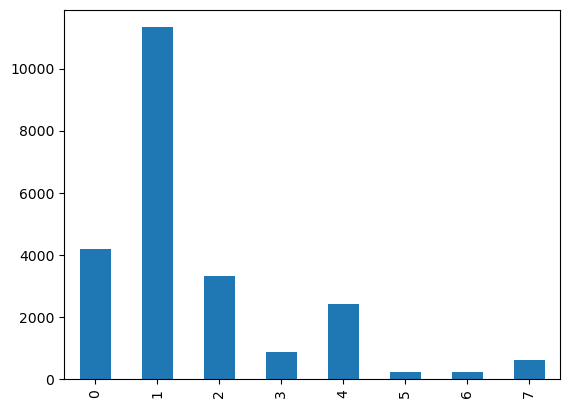

In [33]:
data_dist = data_truth.iloc[:,1:-1].sum()
data_truth.iloc[:,1:-1].sum().plot(kind='bar')
# data_truth.iloc[:,1:-1].value_counts().plot(kind='bar')
data_dist.index = data_dist.index.map(classes_to_int)
data_dist.plot(kind='bar')

<Axes: title={'center': 'Categorical data distribution of whole data set'}, xlabel='Diagnostic categories', ylabel='Number of data'>

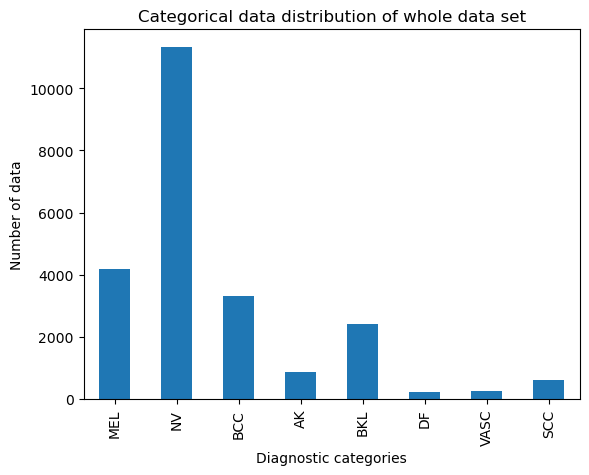

In [15]:
data_truth.iloc[:,1:-1].sum().plot(kind='bar',title="Categorical data distribution of whole data set", xlabel="Diagnostic categories", ylabel = "Number of data")

In [16]:
classes_to_int

{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7}

In [17]:
merged_df = data_truth.merge(meta_data, how='inner', on='image')
merged_df = merged_df.loc[:,['image','labels','dataset']]
merged_df['dataset']= merged_df['dataset'].replace('BCN_nan', 'BCN').replace('MSK4nan', 'MSK4')
merged_df = merged_df.iloc[:,1:]


In [41]:
merged_df['dataset'].unique()
client_dist_df = pd.DataFrame()
for i in merged_df['dataset'].unique():
    client_df = merged_df[merged_df['dataset']==i]
    tmp_dict = client_df['labels'].value_counts().to_dict()
    tmp_dict["center"] = i
    row_df = pd.DataFrame([ tmp_dict])
    client_dist_df = pd.concat([client_dist_df,row_df] , ignore_index=True)
# print(client_df['labels'].value_counts().to_dict())
# print(pd.DataFrame([client_df['labels'].value_counts().to_dict()]))
tmp_df = client_dist_df.set_index('center').fillna(0).astype(int)
tmp_df = tmp_df.reindex(sorted(tmp_df.columns), axis=1)
tmp_df

,0,1,2,3,4,5,6,7
center,,,,,,,,
MSK4,215,415,0,0,189,0,0,0
HAM_vidir_molemax,24,3720,2,0,124,30,54,0
HAM_vidir_modern,680,1832,211,21,475,51,82,11
HAM_rosendahl,342,803,296,109,490,30,3,186
HAM_vienna_dias,67,350,5,0,10,4,3,0
BCN,2857,4206,2809,737,1138,124,111,431


<Axes: ylabel='center'>

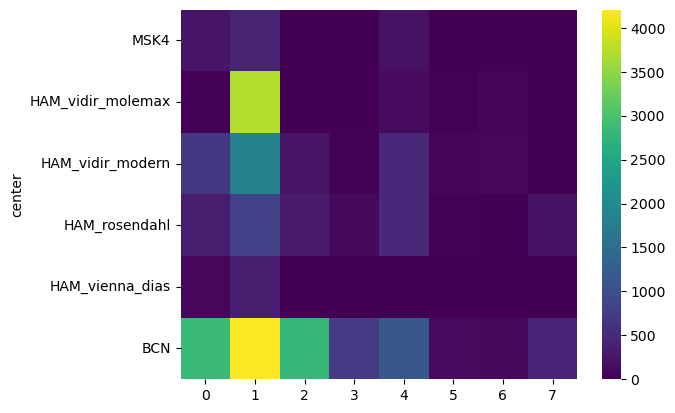

In [42]:
# plt.imshow(client_dist_df)
# plt.colorbar()
# plt.show()
# client_dist_df.pivot_table(index='center')
sns.heatmap(tmp_df, cmap='viridis')
